In [1]:
# #for downloading dataset
# from google.colab import files

# files.upload()
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d datatattle/covid-19-nlp-text-classification

In [2]:
# !pip install transformers datasets


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You

In [4]:
import os
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
# import tensorflow_addons as tfa
from official.nlp import optimization
import numpy as np

tf.get_logger().setLevel('ERROR')

/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [6]:
import os


if tf.config.list_physical_devices('GPU'):
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recommended.')

Using GPU


In [7]:
#@title Choose a BERT model to fine-tune

bert_model_name = "small_bert/bert_en_uncased_L-2_H-256_A-4"
 #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [8]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization  # to create AdamW optimizer


class Model():
  def __init__(self):
    pass  

  def load_saved_model(self, path):
    '''
    Arguments: 
          path to saved model

    '''
    self.model = tf.keras.models.load_model(path)
  
  def load_model(self,model_name,model_url,preprocessor_url,num_classes=2):
    '''
     Load some bert model for fine tuning
     Arguments:
        model_url: url to bert model
        model_name: name of the model
        preprocess_url: url to preprocess model
     
    '''
    self.model_url = model_url
    self.model_name = model_name
    self.preprocessor_url = preprocessor_url
    self.bert_preprocess_model = hub.KerasLayer(self.preprocessor_url)
    self.bert_model = hub.KerasLayer(self.model_url)
    self.model = self.build_model(num_classes)

  def build_model(self,num_classes):
    ''' 
     build model for text classification using bert model
    '''
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(self.preprocessor_url, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(self.model_url, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(num_classes, activation='softmax', name='classifier')(net)
    return tf.keras.Model(text_input, net)

  def predict(self,input):
    '''
     Arguments:
         input: input as string or list of strings
     Returns:
         predictions: list of prediction as tuple of (0/1 ,score)
    '''
    model_predictions = self.model.predict(tf.constant(input))
    predictions = []
    for i in range(input):
      predictions.append((1 if model_predictions[i]>0.5 else 0,model_predictions[i]))
    return predictions

  def train(self,train_dataset,val_dataset,loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
      metrics = tf.metrics.BinaryAccuracy(),epochs = 10,
      init_lr = 3e-5):
   '''
     Train the model on the data
     Arguments:
          train_dataset: training dataset
          val_dataset: validation dataset
          loss: loss function (default binary cross entropy)
          metrics: metrics to be used (default binary accuracy)
          epochs: number of epochs (default 5)
          init_lr: initial learning rate  (default 3e-5)
   '''
   steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
   num_train_steps = steps_per_epoch * epochs

   num_warmup_steps = int(0.1*num_train_steps)
   optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
                                          
   self.model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)
   self.model.fit(x=train_dataset,validation_data=val_dataset,
                               epochs=epochs)

In [9]:
import pandas as pd
#read  /content/Corona_NLP_train.csv

train=pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
test=pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
train

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


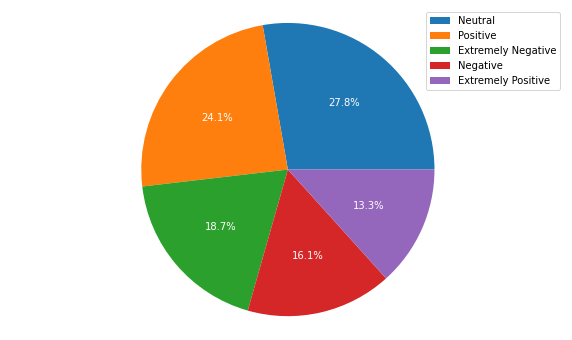

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.pie(train['Sentiment'].value_counts(), labels=train['Sentiment'].unique(), autopct='%.1f%%', textprops={'color':"w"})
plt.legend(loc='upper right')
plt.axis('equal')
plt.show()

In [11]:
#assign numbers to Sentiment labels
train['Sentiment'] = train['Sentiment'].replace(['Negative','Neutral','Positive','Extremely Negative','Extremely Positive'],[1,0,2,3,4])

In [12]:
test['Sentiment'] = test['Sentiment'].replace(['Negative','Neutral','Positive','Extremely Negative','Extremely Positive'],[1,0,2,3,4])

In [13]:
#convert to tensorflow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train['OriginalTweet'].values, train['Sentiment'].values)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((test['OriginalTweet'].values, test['Sentiment'].values)).batch(64)

In [14]:
#load bert model
bert_model = Model()
bert_model.load_model(bert_model_name,tfhub_handle_encoder,tfhub_handle_preprocess,num_classes=5)



2022-06-19 03:03:04.053431: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


In [15]:
bert_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [16]:
#loss sparse categorical cross entropy
loss=tf.keras.losses.SparseCategoricalCrossentropy()
metric=tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
bert_model.train(train_dataset,test_dataset,loss,metric)

Epoch 1/10
644/644 [==============================] - 137s 207ms/step - loss: 1.5154 - accuracy: 0.3180 - val_loss: 1.1731 - val_accuracy: 0.4926
Epoch 2/10
644/644 [==============================] - 133s 206ms/step - loss: 1.0285 - accuracy: 0.5682 - val_loss: 0.8976 - val_accuracy: 0.6438
Epoch 3/10
644/644 [==============================] - 133s 206ms/step - loss: 0.8423 - accuracy: 0.6646 - val_loss: 0.8039 - val_accuracy: 0.6817
Epoch 4/10
644/644 [==============================] - 133s 207ms/step - loss: 0.7539 - accuracy: 0.7053 - val_loss: 0.7557 - val_accuracy: 0.7083
Epoch 5/10
644/644 [==============================] - 133s 207ms/step - loss: 0.6928 - accuracy: 0.7324 - val_loss: 0.7338 - val_accuracy: 0.7191
Epoch 6/10
644/644 [==============================] - 133s 207ms/step - loss: 0.6432 - accuracy: 0.7556 - val_loss: 0.7079 - val_accuracy: 0.7299
Epoch 7/10
644/644 [==============================] - 133s 206ms/step - loss: 0.6157 - accuracy: 0.7657 - val_loss: 0.6954 -

Now try using BertTweet 

In [24]:
from transformers import AutoModel, AutoTokenizer,TFAutoModelForSequenceClassification ,AutoConfig


config = AutoConfig.from_pretrained("vinai/bertweet-base",num_labels=5)
berttweet = TFAutoModelForSequenceClassification.from_config(config)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",num_labels=5)




emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
#tokenize train and test
x_train=train['OriginalTweet'].values
x_test=test['OriginalTweet'].values
y_train=train['Sentiment'].values
y_test=test['Sentiment'].values
#tokenize train and test
tr_tok=tokenizer(list(x_train),return_tensors='tf', truncation=True, padding=True, max_length=128)
te_tok=tokenizer(list(x_test),return_tensors='tf', truncation=True, padding=True, max_length=128)

In [26]:
tr_tok.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [27]:
#select attention_mask and input_ids and token_type_ids
tr_tok_ids=tr_tok['input_ids']
te_tok_ids=te_tok['input_ids']

tr_att_mask=tr_tok['attention_mask']
te_att_mask=te_tok['attention_mask']
tr_tok_type=tr_tok['token_type_ids']
te_tok_type=te_tok['token_type_ids']
#concate attention_mask and input_ids and token_type_ids
tr_tok_train=tf.concat([tr_att_mask,tr_tok_ids,tr_tok_type],axis=-1)
te_tok_test=tf.concat([te_att_mask,te_tok_ids,te_tok_type],axis=-1)

In [28]:
import tensorflow as tf
#map to number
train['Sentiment'] = train['Sentiment'].replace(['Negative','Neutral','Positive','Extremely Negative','Extremely Positive'],[1,0,2,3,4])
test['Sentiment'] = test['Sentiment'].replace(['Negative','Neutral','Positive','Extremely Negative','Extremely Positive'],[1,0,2,3,4])
y_train=train['Sentiment'].values
y_test=test['Sentiment'].values


In [29]:
train_data=tf.data.Dataset.from_tensor_slices((tr_tok_ids,tr_att_mask,y_train)).batch(32)
test_data=tf.data.Dataset.from_tensor_slices((te_tok_test,y_test)).batch(32)



In [30]:
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric=tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
berttweet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=loss,metrics=metric)
berttweet.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [ ]:
#import train

In [31]:
berttweet.fit(x=train_data,validation_data=test_data,epochs=2,verbose=1)

Epoch 1/2


ValueError: in user code:

    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/transformers/modeling_tf_utils.py", line 1156, in train_step
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 501, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 70, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/metrics/base_metric.py", line 646, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/studio-lab-user/.conda/envs/hf/lib/python3.10/site-packages/keras/utils/metrics_utils.py", line 885, in sparse_categorical_matches  **
        y_true = tf.squeeze(y_true, [-1])

    ValueError: Can not squeeze dim[1], expected a dimension of 1, got 128 for '{{node Squeeze}} = Squeeze[T=DT_FLOAT, squeeze_dims=[-1]](Cast_3)' with input shapes: [?,128].


In [ ]:
input_ids = tf.keras.Input(shape=(128,), dtype='int32')
attention_mask = tf.keras.Input(shape=(128, ), dtype='int32')

encoded = berttweet({"input_ids": input_ids, "attention_mask": attention_mask})
logits = encoded[0]
 
model = tf.keras.models.Model(inputs = {"input_ids": input_ids, "attention_mask": attention_mask}, outputs = logits)
model.summary()